# FACEBOOK ADS

#### For more information you can check the link below:
#### https://developers.facebook.com/docs/marketing-api/targeting-search/

In [1]:
!pip install facebook-business

In [2]:
# -*- coding: utf-8 -*-
__author__ = "Carolina Coimbra Vieira"

from facebook_business.adobjects.adaccount import AdAccount
from facebook_business.adobjects.adset import AdSet
from facebook_business.adobjects.targetingsearch import TargetingSearch
from facebook_business.api import FacebookAdsApi
from facebook_business.exceptions import FacebookError
from unicodedata import normalize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import pandas as pd
import time
import random

## FUNCTIONS TO MAKE REQUESTS

In [3]:
# Initialize the account

# PLEASE, UPDATE THE VERSION IF NECESSARY!
def get_ad_account(token, act_id, secret):

    if secret != '-':
        facebook_api = FacebookAdsApi.init(access_token=token, app_secret=secret, api_version='v16.0') #version
    else:
        facebook_api = FacebookAdsApi.init(access_token=token, api_version='v16.0') #version

    account = AdAccount('act_' + act_id)
    
    return facebook_api, account

In [4]:
# Return the audience for a specific target
def make_request(account, targeting_spec):
    api_params = {
        'targeting_spec': targeting_spec
    }
    
    reach_estimate = account.get_reach_estimate(params=api_params)
    number_l = reach_estimate[0]['users_lower_bound']
    number_u = reach_estimate[0]['users_upper_bound']
    return number_l, number_u

In [5]:
# Return the interest id
def get_expatsID_from_text(api, text, limit=10):
    params = {
        'q': text,        
        'type': 'adTargetingCategory',
        'class': 'behaviors',
        'limit': limit,        
    }
    
    resp = TargetingSearch.search(params=params, api=api)

    
    expats = []
    for item in resp:
        name = item.get('name', '').lower()
        path = ' / '.join(item.get('path', [])).lower() if item.get('path') else ''
        if 'expat' in name or 'expat' in path:
            expats.append({
                'id': item.get('id'),
                'name': item.get('name'),
                'audience_size': item.get('audience_size'),
                'path': item.get('path')
            })
    
    return expats

In [6]:
# Return the interest id
def get_interestID_from_text(api, text, limit=10):
    params = {
        'q': text,        
        'type': 'adinterest',
        'limit': limit,        
    }
    
    resp = TargetingSearch.search(params=params, api=api)
    return resp

In [7]:
# Return the location key
def get_location_element(api, element, location_type="country"):   
    params = {
        'q': element,
        'type': 'adgeolocation',
        'location_types': [location_type], #['city'] OR ['region'] OR ['country'] OR ['country_group']
    }
    
    responses = TargetingSearch.search(params=params, api=api)
    return responses

In [8]:
# Return a dictionary with the informations abount the interests
def test_interest_search(api, list_of_interests_to_search): 
    
    print("interest_id \t name \t audience_size \t type")
       
    interests_dict = dict()

    for interest in list_of_interests_to_search:
        search_result = get_interestID_from_text(api, interest)
         
        #search_result can include (from zero to limit=10) interests related to your search
        if search_result:
            element = search_result[0] # get first interest returned
            
            #Only if the name is exactly the same as you search!
            if interest.lower() == element["name"].lower():
                e_id = element["id"]
                e_name = interest
                e_audience_l = element["audience_size_lower_bound"]
                e_audience_u = element["audience_size_upper_bound"]
                
                #not all responses have a topic and category defined. 
                try:
                    e_type = element["topic"]
                except:
                    e_type = ""
                    
                #add interest information to the dictionary (key: interest name)
                interests_dict[e_name] = {"id": e_id, 
                                          "audience_lower": e_audience_l, 
                                          "audience_upper": e_audience_u, 
                                          "type": e_type}

                print (str(e_id), str(e_name), str(e_audience_l), str(e_audience_u), str(e_type))
          
    return interests_dict


In [9]:
# Return a dictionary with the informations abount the locations
def test_search_location_code(api, list_of_locations_and_types_to_search):
    
    print("key \t name \t location_type")
    
    locations_dict = dict()
    
    for location, l_type in list_of_locations_and_types_to_search:
        search_result = get_location_element(api, location, location_type = l_type)  
        
        #search_result can include (from zero to ?) locations related to your search
        if search_result:
            element = search_result[0] # get first interest returned

            #Only if the name is exactly the same as you search!
            if location == element["name"]:
                e_key = element["key"]
                e_name = element["name"]
                e_type = element["type"]

                locations_dict[e_name] = {"key": e_key, "type": e_type}

                print (str(e_key), str(e_name), str(e_type))
            
    return locations_dict

## INITIALIZE YOUR ACCOUNT

In [10]:
#COMPLETE YOUR TOKEN
token = "ADD YOUR TOKEN HERE"
#COMPLETE YOUR APP ID
act_id = "ADD YOUR ACCOUNT ID HERE"
secret = "-"
  
facebook_api, account = get_ad_account(token, act_id, secret)

## EXAMPLES:

### Collecting some interests id

In [11]:
list_of_interests_to_search = ['organic food', 'fast food', 'veganism', 'vegetarianism',
                               'pretzel', 'barbecue', 'sausage', 'pizza', 'seafood',
                               'football', 'basketball', 'volleyball', 'cycling']

In [12]:
print("INTERESTS TO SEARCH:")
interests_dict = test_interest_search(facebook_api, list_of_interests_to_search)

INTERESTS TO SEARCH:
interest_id 	 name 	 audience_size 	 type
6002868910910 organic food 273132221 321203492 Food and drink
6004037400009 fast food 445818967 524283106 Food and drink
6003641846820 veganism 324563265 381686400 Food and drink
6003155333705 vegetarianism 207809507 244383981 Food and drink
6003130694636 pretzel 6137568 7217780 Food and drink
6003435096731 barbecue 348044897 409300800 Food and drink
6002968797092 sausage 53667253 63112690 Food and drink
6003668857118 pizza 441634838 519362570 Food and drink
6003240742699 seafood 270206906 317763322 Food and drink
6003442346642 football 86429591 101641200 Sports and outdoors
6003369240775 basketball 714404481 840139670 Sports and outdoors
6002929380259 volleyball 342179787 402403430 Sports and outdoors
6003402532547 cycling 196664226 231277130 Fitness and wellness


In [13]:
interests = pd.DataFrame.from_dict(interests_dict, orient="index")
interests.to_csv("data/interests.csv")

### Collecting some locations key

In [14]:
#available location types: country, country_group, region, city
list_of_locations_to_search = [('Brazil', 'country'), 
                               ('Germany', 'country')]

In [15]:
print("LOCATIONS TO SEARCH:")
locations_dict = test_search_location_code(facebook_api, list_of_locations_to_search)

LOCATIONS TO SEARCH:
key 	 name 	 location_type
BR Brazil country
DE Germany country


### Collecting some behavior ID

In [16]:
get_expatsID_from_text(facebook_api, "")

[{'id': '6015559470583',
  'name': 'Lives abroad',
  'audience_size': None,
  'path': ['Expats', 'Lives abroad']},
 {'id': '6016916298983',
  'name': 'Lived in India (Formerly Expats - India)',
  'audience_size': None,
  'path': ['Expats', 'Lived in India (Formerly Expats - India)']},
 {'id': '6018796980983',
  'name': 'Lived in Kenya (Formerly Expats - Kenya)',
  'audience_size': None,
  'path': ['Expats', 'Lived in Kenya (Formerly Expats - Kenya)']},
 {'id': '6018797004183',
  'name': 'Lived in Nigeria (Formerly Expats - Nigeria)',
  'audience_size': None,
  'path': ['Expats', 'Lived in Nigeria (Formerly Expats - Nigeria)']},
 {'id': '6018797036783',
  'name': 'Lived in Cameroon (Formerly Expats - Cameroon)',
  'audience_size': None,
  'path': ['Expats', 'Lived in Cameroon (Formerly Expats - Cameroon)']},
 {'id': '6018797091183',
  'name': 'Lived in Philippines (Formerly Expats - Philippines)',
  'audience_size': None,
  'path': ['Expats', 'Lived in Philippines (Formerly Expats - Phi

### Defining your target
#### In this example we want all the Facebook users who are between 13 and 65+ years old.

For more information, see: https://developers.facebook.com/docs/marketing-api/audiences/reference

In [17]:
targeting_spec = {
    "publisher_platforms": ["facebook", "instagram"], #platform: facebook, instagram
    "facebook_positions": ["feed"], #where the ad would be displayed: feed, right_hand_column, instream_video
    #"genders": #,Defaults to all. 1 targets males, 2 targets females.
    "age_min": 13, #The min age default is 18, so I've changed to 13. The max age default is 65+
    #"age_max": #, #The max age default is 65+
    "excluded_publisher_categories": [],
    "excluded_publisher_list_ids": [],
    "user_device": [],
    "excluded_user_device": [],
    "user_os": [],
    "wireless_carrier": [],
    'behaviors': [],
    'interests': [],
    "flexible_spec": []        
}

### Collecting the audience in each country

In [18]:
for location in locations_dict:
    #Adding the information about the location of our target
    if locations_dict[location]["type"] == "country":
        targeting_spec["geo_locations"] = {"countries":[locations_dict[location]["key"]]}
    else:
        targeting_spec["geo_locations"] = {"regions":[{"key":locations_dict[location]["key"]}]}
    
    #We will not specify interests because we are interested on the country audience
    targeting_spec["interests"] = []
        
    audience_size_l, audience_size_u = make_request(account,targeting_spec)
    
    print ("Population in ", location, ":", str(audience_size_l), "-", str(audience_size_u))
    
    locations_dict[location]["audience_lower"] = audience_size_l
    locations_dict[location]["audience_upper"] = audience_size_u

Population in  Brazil : 162900000 - 191600000
Population in  Germany : 39100000 - 46000000


In [19]:
for location in locations_dict:
    #Adding the information about the location of our target
    if locations_dict[location]["type"] == "country":
        targeting_spec["geo_locations"] = {"countries":[locations_dict[location]["key"]]}
    else:
        targeting_spec["geo_locations"] = {"regions":[{"key":locations_dict[location]["key"]}]}
    
    #We will not specify interests because we are interested on the country audience
    targeting_spec["interests"] = []
    targeting_spec["behaviors"] = [6015559470583] # 'Lives abroad'
        
    audience_size_l, audience_size_u = make_request(account,targeting_spec)
    
    print ("Population in ", location, ":", str(audience_size_l), "-", str(audience_size_u))
    
    locations_dict[location]["audience_lower"] = audience_size_l
    locations_dict[location]["audience_upper"] = audience_size_u

Population in  Brazil : 948600 - 1100000
Population in  Germany : 2800000 - 3300000


In [20]:
locations_dict

{'Brazil': {'key': 'BR',
  'type': 'country',
  'audience_lower': 948600,
  'audience_upper': 1100000},
 'Germany': {'key': 'DE',
  'type': 'country',
  'audience_lower': 2800000,
  'audience_upper': 3300000}}

In [21]:
locations = pd.DataFrame.from_dict(locations_dict, orient="index")
locations.to_csv("data/locations.csv")

### Collecting the audience in each interests for each country

https://developers.facebook.com/docs/graph-api/overview/rate-limiting

In [22]:
dict_info = dict()

for location in locations_dict:
    
    dict_info[location] = dict()
    
    #Adding the information about the location of our target
    if locations_dict[location]["type"] == "country":
        targeting_spec["geo_locations"] = {"countries":[locations_dict[location]["key"]]}
    else:
        targeting_spec["geo_locations"] = {"regions":[{"key":locations_dict[location]["key"]}]}

    for interest in interests_dict:
        #Adding the information about the interest we are looking for
        targeting_spec["interests"] = [interests_dict[interest]["id"]]

        try:
            audience_size_l, audience_size_u = make_request(account,targeting_spec)
            
        except:
            #Wait for 3600s for next request
            time.sleep(3600)
            
            try:
                audience_size_l, audience_size_u = make_request(account,targeting_spec)
                
            except:
                audience_size_l = 0
                audience_size_u = 0
                print("Error!", location, interest)
            
        finally:
            print ("Population in " + str(location) + " interested in " + str(interest) + " = " + str(audience_size_l), str(audience_size_u))
            dict_info[location][interest] = {"audience_lower": audience_size_l, 
                                             "%audience_lower_country": float(audience_size_l/float(locations_dict[location]["audience_lower"])),
                                             "audience_upper": audience_size_u, 
                                             "%audience_upper_country": float(audience_size_u/float(locations_dict[location]["audience_upper"]))}
            #Wait from 1 to 10 seconds between requests
            time.sleep(random.randint(1, 10))

Population in Brazil interested in organic food = 146100 171900
Population in Brazil interested in fast food = 272000 320000
Population in Brazil interested in veganism = 107800 126800
Population in Brazil interested in vegetarianism = 170700 200900
Population in Brazil interested in pretzel = 1000 1000
Population in Brazil interested in barbecue = 215700 253800
Population in Brazil interested in sausage = 22400 26300
Population in Brazil interested in pizza = 106800 125600
Population in Brazil interested in seafood = 64800 76200
Population in Brazil interested in football = 284200 334300
Population in Brazil interested in basketball = 126300 148600
Population in Brazil interested in volleyball = 169400 199300
Population in Brazil interested in cycling = 173200 203800
Population in Germany interested in organic food = 593900 698700
Population in Germany interested in fast food = 440300 517900
Population in Germany interested in veganism = 568600 668900
Population in Germany interested 

In [23]:
reformed_dict = {}
for outer_key, inner_dict in dict_info.items():
    for inner_key, values in inner_dict.items():
        reformed_dict[(outer_key, inner_key)] = values

# Display multiindex dataframe
df = pd.DataFrame(reformed_dict).T
df

audience_lower  %audience_lower_country  \
Brazil  organic food         146100.0                 0.154016   
        fast food            272000.0                 0.286738   
        veganism             107800.0                 0.113641   
        vegetarianism        170700.0                 0.179949   
        pretzel                1000.0                 0.001054   
        barbecue             215700.0                 0.227388   
        sausage               22400.0                 0.023614   
        pizza                106800.0                 0.112587   
        seafood               64800.0                 0.068311   
        football             284200.0                 0.299599   
        basketball           126300.0                 0.133144   
        volleyball           169400.0                 0.178579   
        cycling              173200.0                 0.182585   
Germany organic food         593900.0                 0.212107   
        fast food            440300.0                 0.157250   
        veganism             568600.0                 0.203071   
        vegetarianism        543300.0                 0.194036   
        pretzel               11000.0                 0.003929   
        barbecue             428300.0                 0.152964   
        sausage              114700.0                 0.040964   
        pizza                225700.0                 0.080607   
        seafood              158100.0                 0.056464   
        football             609600.0                 0.217714   
        basketball           384900.0                 0.137464   
        volleyball           387000.0                 0.138214   
        cycling              678400.0                 0.242286   

                       audience_upper  %audience_upper_country  
Brazil  organic food         171900.0                 0.156273  
        fast food            320000.0                 0.290909  
        veganism             126800.0                 0.115273  
        vegetarianism        200900.0                 0.182636  
        pretzel                1000.0                 0.000909  
        barbecue             253800.0                 0.230727  
        sausage               26300.0                 0.023909  
        pizza                125600.0                 0.114182  
        seafood               76200.0                 0.069273  
        football             334300.0                 0.303909  
        basketball           148600.0                 0.135091  
        volleyball           199300.0                 0.181182  
        cycling              203800.0                 0.185273  
Germany organic food         698700.0                 0.211727  
        fast food            517900.0                 0.156939  
        veganism             668900.0                 0.202697  
        vegetarianism        639100.0                 0.193667  
        pretzel               13000.0                 0.003939  
        barbecue             503900.0                 0.152697  
        sausage              134900.0                 0.040879  
        pizza                265500.0                 0.080455  
        seafood              186000.0                 0.056364  
        football             717100.0                 0.217303  
        basketball           452800.0                 0.137212  
        volleyball           455300.0                 0.137970  
        cycling              798100.0                 0.241848

In [24]:
df.to_csv("data/toy-example.csv")

In [25]:
df = pd.read_csv("data/toy-example.csv", index_col=[0,1])
df

audience_lower  %audience_lower_country  \
Brazil  organic food         146100.0                 0.154016   
        fast food            272000.0                 0.286738   
        veganism             107800.0                 0.113641   
        vegetarianism        170700.0                 0.179949   
        pretzel                1000.0                 0.001054   
        barbecue             215700.0                 0.227388   
        sausage               22400.0                 0.023614   
        pizza                106800.0                 0.112587   
        seafood               64800.0                 0.068311   
        football             284200.0                 0.299599   
        basketball           126300.0                 0.133144   
        volleyball           169400.0                 0.178579   
        cycling              173200.0                 0.182585   
Germany organic food         593900.0                 0.212107   
        fast food            440300.0                 0.157250   
        veganism             568600.0                 0.203071   
        vegetarianism        543300.0                 0.194036   
        pretzel               11000.0                 0.003929   
        barbecue             428300.0                 0.152964   
        sausage              114700.0                 0.040964   
        pizza                225700.0                 0.080607   
        seafood              158100.0                 0.056464   
        football             609600.0                 0.217714   
        basketball           384900.0                 0.137464   
        volleyball           387000.0                 0.138214   
        cycling              678400.0                 0.242286   

                       audience_upper  %audience_upper_country  
Brazil  organic food         171900.0                 0.156273  
        fast food            320000.0                 0.290909  
        veganism             126800.0                 0.115273  
        vegetarianism        200900.0                 0.182636  
        pretzel                1000.0                 0.000909  
        barbecue             253800.0                 0.230727  
        sausage               26300.0                 0.023909  
        pizza                125600.0                 0.114182  
        seafood               76200.0                 0.069273  
        football             334300.0                 0.303909  
        basketball           148600.0                 0.135091  
        volleyball           199300.0                 0.181182  
        cycling              203800.0                 0.185273  
Germany organic food         698700.0                 0.211727  
        fast food            517900.0                 0.156939  
        veganism             668900.0                 0.202697  
        vegetarianism        639100.0                 0.193667  
        pretzel               13000.0                 0.003939  
        barbecue             503900.0                 0.152697  
        sausage              134900.0                 0.040879  
        pizza                265500.0                 0.080455  
        seafood              186000.0                 0.056364  
        football             717100.0                 0.217303  
        basketball           452800.0                 0.137212  
        volleyball           455300.0                 0.137970  
        cycling              798100.0                 0.241848

### Plots

In [26]:
def plot_audience(location, df, norm=False, interests_list=None):
    
    df = df.loc[location] #dataframe for one location only
    
    if interests_list:
        df = df.loc[interests_list] #dataframe only for a set of interests
        
    df["audience_upper"] = df["audience_upper"]-df["audience_lower"]
    df["%audience_upper_country"] = df["%audience_upper_country"]-df["%audience_lower_country"]
    
    if norm:
        df[["%audience_lower_country", "%audience_upper_country"]].plot.barh(stacked=True)
    else:
        df[["audience_lower", "audience_upper"]].plot.barh(stacked=True)
        
    plt.title(location)
    plt.xlabel("audience")
    plt.ylabel("interests")
    
    plt.show()

Brazil


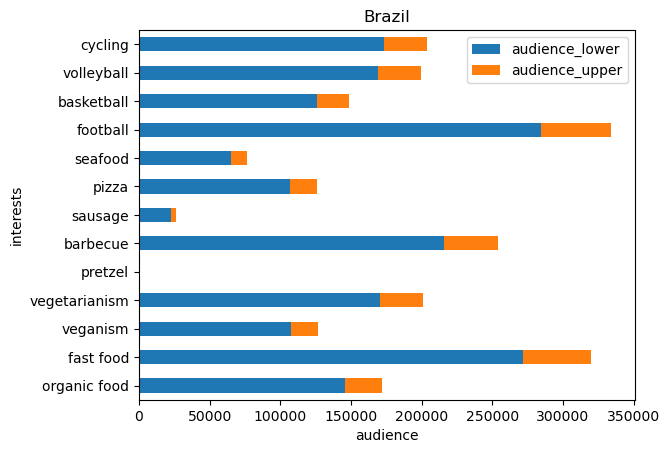

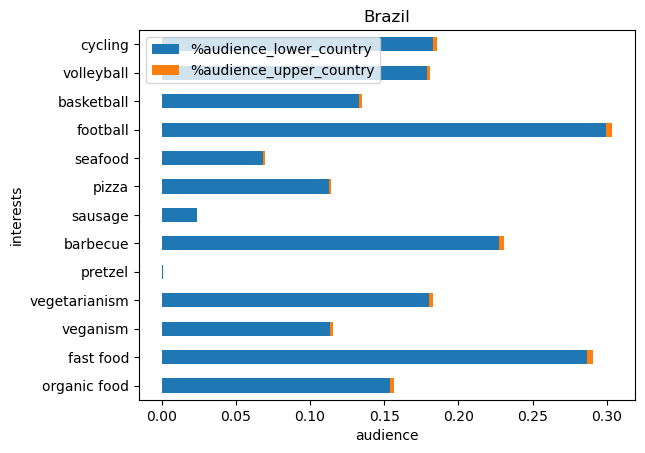

Germany


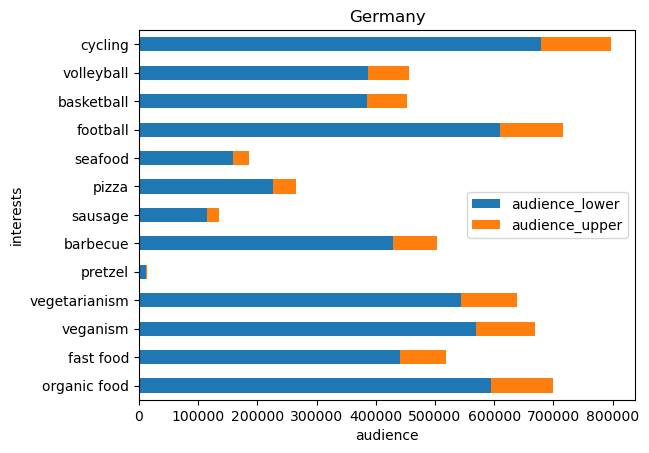

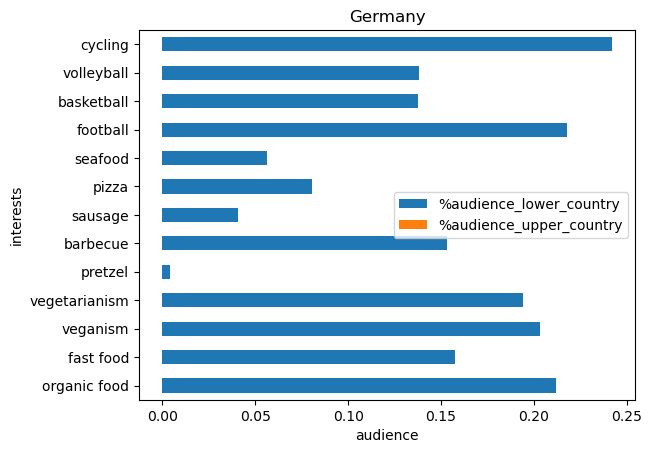

In [27]:
for location in set(df.index.get_level_values(level=0)):
    print(location)
    plot_audience(location, df)
    plot_audience(location, df, norm=True)    

#### Things to be aware of:
Audience lower-bound: 1,000  

Sometimes it's helpeful to normalize: %location, %interest, z-score, etc.